# Example usage
## Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import skorch
import torch
from matplotlib import pyplot as plt

from time_series_predictor import TimeSeriesPredictor
from src.model import BenchmarkLSTM
from src.oze_dataset import OzeNPZDataset, npz_check

## Config

In [2]:
plot_config = {}
plot_config['training progress'] = True
plot_config['prediction on training data'] = True
plot_config['forecast'] = True

forecast_config = {}
forecast_config['include history'] = True
forecast_config['steps ahead'] = 500

predictor_config = {}
predictor_config['epochs'] = 50
predictor_config['learning rate'] = 1e-2
predictor_config['hidden dim'] = 100
predictor_config['layers num'] = 3

config = {}
config['plot'] = plot_config
config['forecast'] = forecast_config
config['predictor'] = predictor_config
config['predict on training data enabled'] = True
config['forecast enabled'] = True

## Time Series Predictor instantiation

In [3]:
tsp = TimeSeriesPredictor(
    BenchmarkLSTM(
        hidden_dim=config['predictor']['hidden dim'],
        num_layers=config['predictor']['layers num']
    ),
    lr=config['predictor']['learning rate'],
    max_epochs=predictor_config['epochs'],
    # train_split=None, # default = skorch.dataset.CVSplit(5)
    optimizer=torch.optim.Adam
)

## Training process

In [4]:
ds = OzeNPZDataset(
    dataset_path=npz_check(
        Path(os.path.join('..', '..', '..', 'datasets')),
        'dataset'
    )
)
tsp.fit(ds)
# training_dataframe = tsp.get_training_dataframe()

Using device cuda
Re-initializing module because the following parameters were re-set: input_dim, output_dim.
Re-initializing optimizer.
  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0806        0.0214  15.3144
      2        0.0170        0.0146  14.9987
      3        0.0141        0.0131  15.2833
      4        0.0125        0.0123  15.4239
      5        0.0113        0.0094  16.0079
      6        0.0085        0.0082  16.1367
      7        0.0072        0.0069  16.4393
      8        0.0070        0.0123  16.9156
      9        0.0086        0.0068  17.7764
     10        0.0059        0.0053  17.6920
     11        0.0053        0.0049  17.3836
     12        0.0048        0.0044  17.3759
     13        0.0060        0.0044  17.3441
     14        0.0037        0.0032  17.1934
     15        0.0031        0.0030  17.2972
     16        0.0030        0.0028  17.2707
     17        0.0029        0.0026  17.4700
     18 

### Plot training evolution

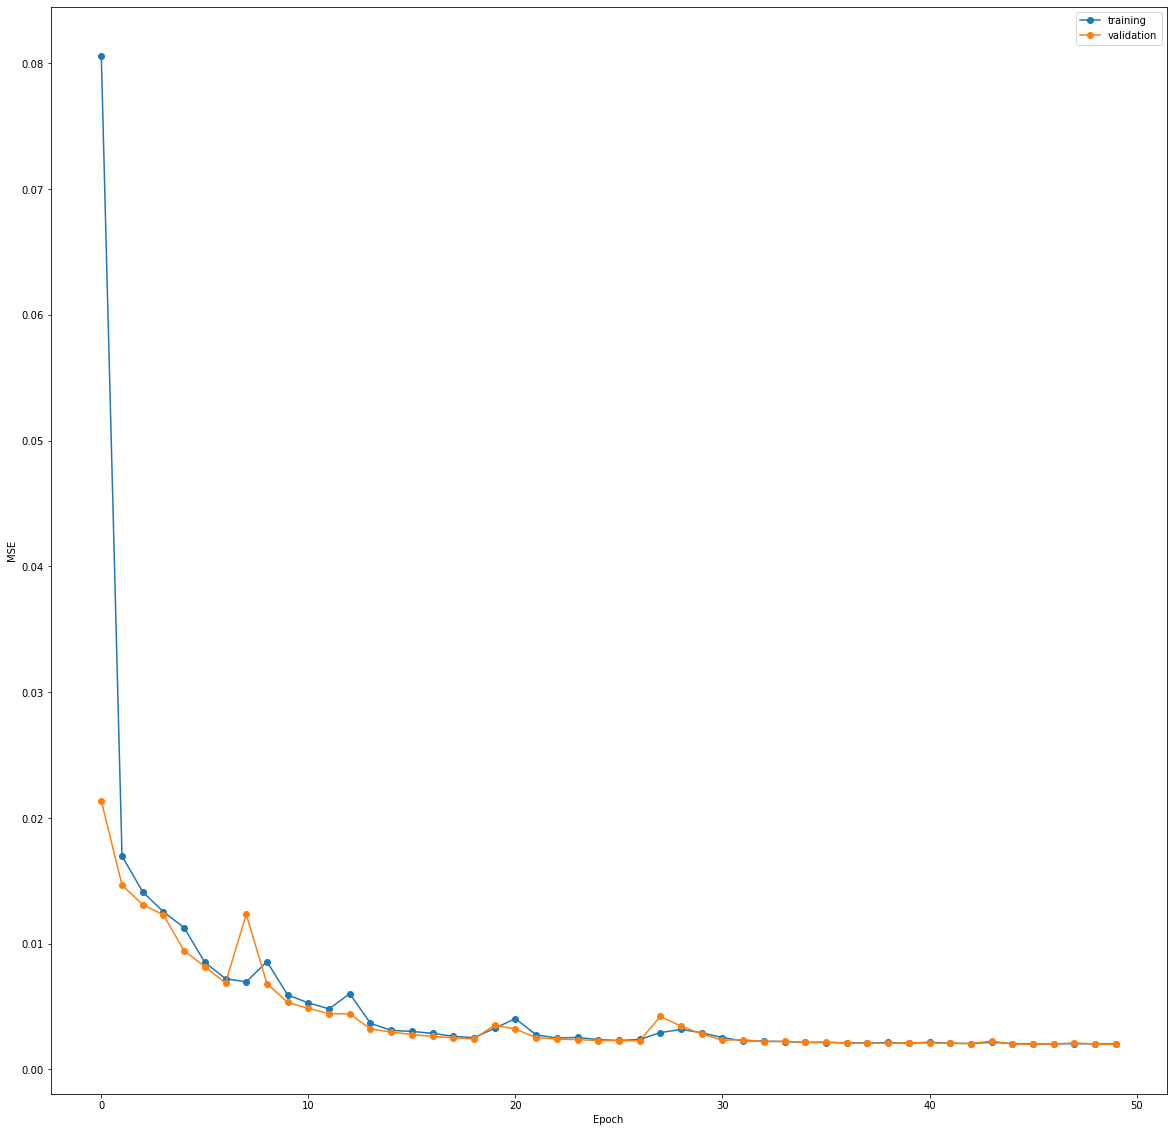

In [5]:
if config['plot']['training progress']:
    history_length = len(tsp.ttr.regressor_['regressor'].history)
    train_loss = np.zeros((history_length, 1))
    valid_loss = np.zeros((history_length, 1))
    for epoch in tsp.ttr.regressor_['regressor'].history:
        epoch_number = epoch['epoch']-1
        train_loss[epoch_number] = epoch['train_loss']
        valid_loss[epoch_number] = epoch['valid_loss']
    plt.figure(figsize=(20, 20))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    axes = plt.axes()
    axes.set_xlabel('Epoch')
    axes.set_ylabel('MSE')
    plt.legend()

## Prediction on training data

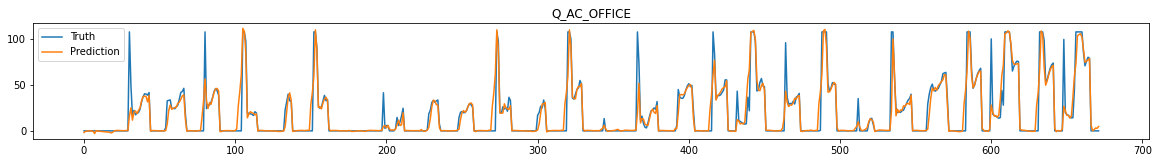

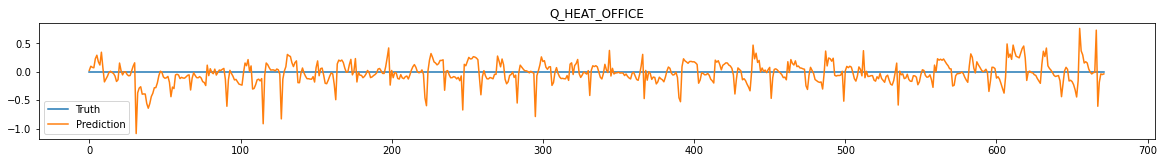

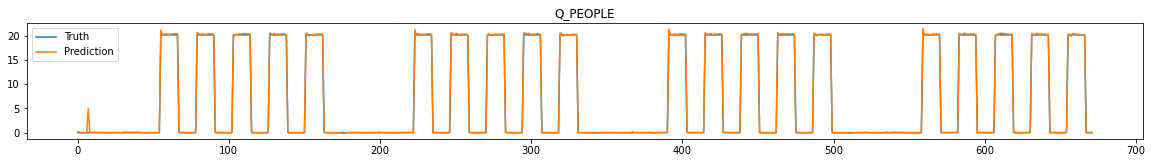

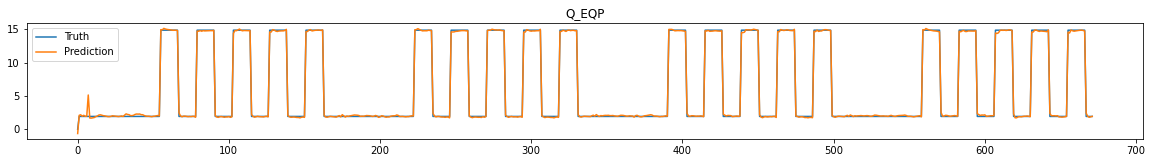

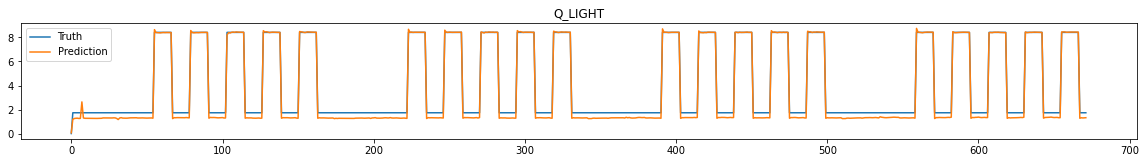

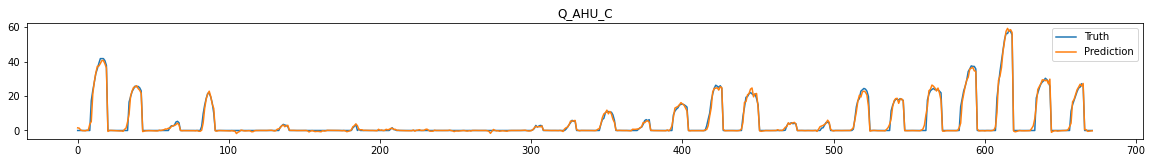

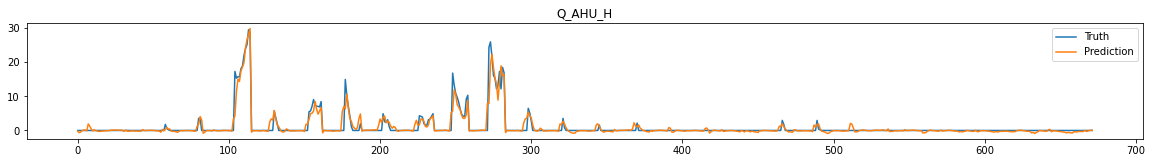

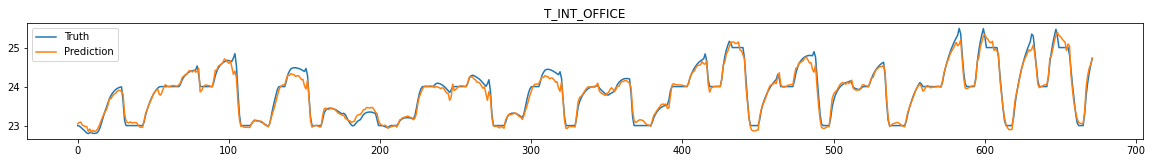

In [6]:
if config['predict on training data enabled']:
    # Select training example
    idx = np.random.randint(0, len(tsp.dataset))
    dataloader = tsp.ttr.regressor['regressor'].get_iterator(tsp.dataset)
    x, y = dataloader.dataset[idx]

    # Run predictions
    netout = tsp.sample_predict(x)

    d_output = netout.shape[1]
    if config['plot']['prediction on training data']:
        plt.figure(figsize=(20, 20))
    for idx_output_var in range(d_output):
        # Select real passengers data
        y_true = y[:, idx_output_var]

        y_pred = netout[:, idx_output_var]

        if config['plot']['prediction on training data']:
            plt.subplot(d_output, 1, idx_output_var+1)

            plt.plot(y_true, label="Truth")
            plt.plot(y_pred, label="Prediction")
            plt.title(tsp.dataset.labels['X'][idx_output_var])
            plt.legend()

## Future forecast

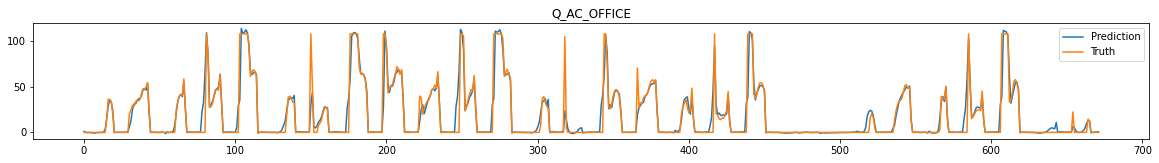

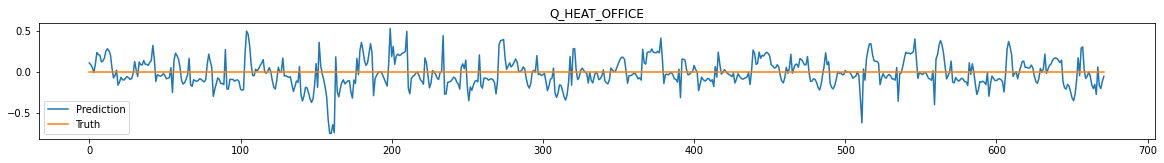

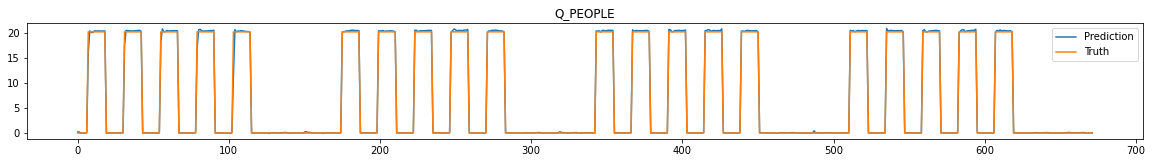

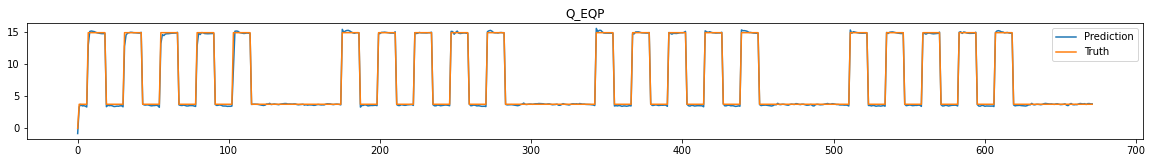

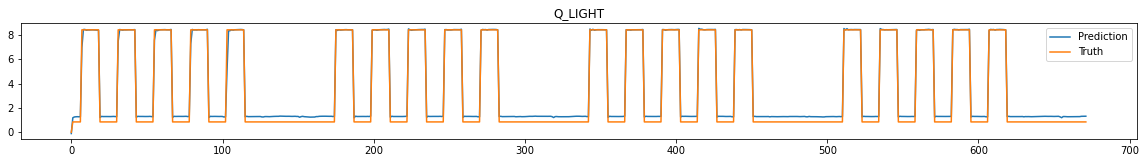

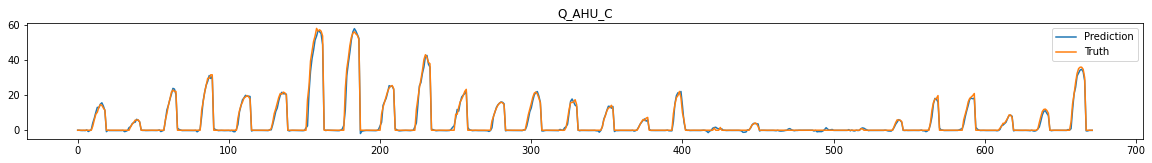

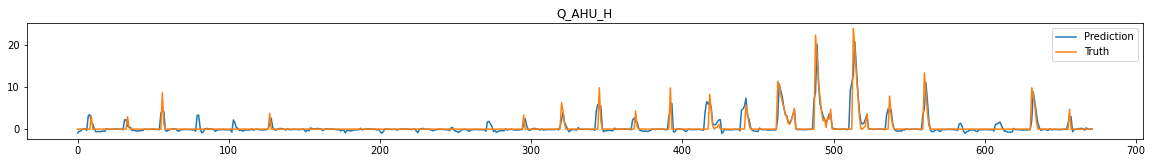

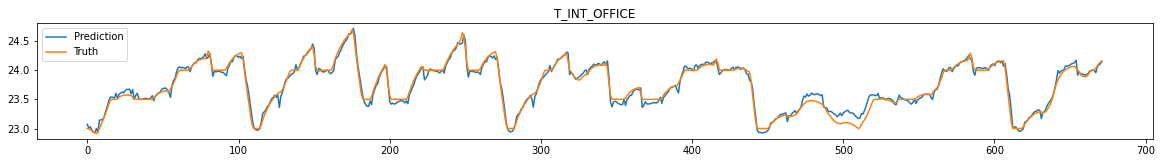

In [7]:
# Run forecast
if config['forecast enabled']:
    netout = tsp.forecast(config['forecast']['steps ahead'],
                          include_history=config['forecast']['include history'])

    d_output = netout.shape[-1]
    # Select any training example just for comparison
    idx = np.random.randint(0, config['forecast']['steps ahead'])
    dataloader = tsp.ttr.regressor['regressor'].get_iterator(tsp.dataset)
    x, y = dataloader.dataset[idx]
    for idx_output_var in range(d_output):
        # Select real passengers data
        y_true = y[:, idx_output_var]

        y_pred = netout[idx, :, idx_output_var]

        if config['plot']['forecast']:
            plt.figure(figsize=(20, 20))
            plt.subplot(d_output, 1, idx_output_var+1)

            if config['forecast']['include history']:
                plot_args = [y_pred]
            else:
                y_pred_index = [i+tsp.dataset.get_x_shape()[1]+1 for i in range(len(y_pred))]
                plot_args = [y_pred_index, y_pred]
            plt.plot(*plot_args, label="Prediction")
            plt.plot(y_true, label="Truth")
            plt.title(tsp.dataset.labels['X'][idx_output_var])
            plt.legend()